In [1]:
import sklearn as sk
import pandas as pd
import numpy as np
from os import getenv
from datetime import datetime
from amb_sdk.sdk import DarwinSdk
import matplotlib.pyplot as plt

%matplotlib inline

pd.set_option('display.max_rows', None)

In [3]:
ds = DarwinSdk()
ds.set_url('https://amb-demo-api.sparkcognition.com/v1/')

status, msg = ds.auth_login_user('danny.diaz@utexas.edu','JcXCnQ7Wx2')
if not status:
    print(msg)
status

True

In [6]:
cycle_df = pd.read_csv('./data/Austin_B-Cycle_Trips.csv')
weather_df = pd.read_csv('./data/austin_weather.csv')

In [8]:
cycle_df['Checkout Date'] = pd.to_datetime(
    cycle_df['Checkout Date'], infer_datetime_format=True
    ).dt.normalize() #strftime('%m/%d/%Y') # format='%m/%d/%Y').dt.date

cycle_df['Checkout Time'] = pd.to_timedelta(
    cycle_df['Checkout Time']) #, format='%H:%M:%S')\
#.dt.strftime('%H:%M') #This turns it back to a object dtype

print(cycle_df.dtypes)
cycle_df.head()
#cycle_df.shape

Trip ID                            int64
Membership Type                   object
Bicycle ID                       float64
Checkout Date             datetime64[ns]
Checkout Time            timedelta64[ns]
Checkout Kiosk ID                float64
Checkout Kiosk                    object
Return Kiosk ID                  float64
Return Kiosk                      object
Trip Duration Minutes              int64
Month                            float64
Year                             float64
dtype: object


Trip ID                     Membership Type  Bicycle ID Checkout Date  \
0  9900285854        Annual (San Antonio B-cycle)       207.0    2014-10-26   
1  9900285855      24-Hour Kiosk (Austin B-cycle)       969.0    2014-10-26   
2  9900285856  Annual Membership (Austin B-cycle)       214.0    2014-10-26   
3  9900285857      24-Hour Kiosk (Austin B-cycle)       745.0    2014-10-26   
4  9900285858      24-Hour Kiosk (Austin B-cycle)       164.0    2014-10-26   

  Checkout Time  Checkout Kiosk ID  \
0      13:12:00             2537.0   
1      13:12:00             2498.0   
2      13:12:00             2537.0   
3      13:12:00                NaN   
4      13:12:00             2538.0   

                                      Checkout Kiosk  Return Kiosk ID  \
0                                     West & 6th St.           2707.0   
1            Convention Center / 4th St. @ MetroRail           2566.0   
2                                     West & 6th St.           2496.0   
3  Zilker Park at Barton Springs & William Barton...              NaN   
4                    Bullock Museum @ Congress & MLK              NaN   

                                        Return Kiosk  Trip Duration Minutes  \
0                               Rainey St @ Cummings                     76   
1                      Pfluger Bridge @ W 2nd Street                     58   
2                                     8th & Congress                      8   
3  Zilker Park at Barton Springs & William Barton...                     28   
4                   Convention Center/ 3rd & Trinity                     15   

   Month    Year  
0   10.0  2014.0  
1   10.0  2014.0  
2   10.0  2014.0  
3   10.0  2014.0  
4   10.0  2014.0

Trip ID                     Membership Type  Bicycle ID Checkout Date  \
0  9900285854        Annual (San Antonio B-cycle)       207.0    2014-10-26   
1  9900285855      24-Hour Kiosk (Austin B-cycle)       969.0    2014-10-26   
2  9900285856  Annual Membership (Austin B-cycle)       214.0    2014-10-26   
3  9900285857      24-Hour Kiosk (Austin B-cycle)       745.0    2014-10-26   
4  9900285858      24-Hour Kiosk (Austin B-cycle)       164.0    2014-10-26   
5  9900285859      24-Hour Kiosk (Austin B-cycle)        37.0    2014-10-26   
6  9900285860  Annual Membership (Austin B-cycle)       517.0    2014-10-26   
7  9900285861  Annual Membership (Austin B-cycle)       996.0    2014-10-26   
8  9900285862  Annual Membership (Austin B-cycle)       517.0    2014-10-26   
9  9900285863      24-Hour Kiosk (Austin B-cycle)       385.0    2014-10-26   

  Checkout Time  Checkout Kiosk ID  \
0      13:12:00             2537.0   
1      13:12:00             2498.0   
2      13:12:00             2537.0   
3      13:12:00                NaN   
4      13:12:00             2538.0   
5      13:12:00                NaN   
6      13:12:00             2496.0   
7      13:12:00             2569.0   
8      13:12:00             2496.0   
9      13:12:00                NaN   

                                      Checkout Kiosk  Return Kiosk ID  \
0                                     West & 6th St.           2707.0   
1            Convention Center / 4th St. @ MetroRail           2566.0   
2                                     West & 6th St.           2496.0   
3  Zilker Park at Barton Springs & William Barton...              NaN   
4                    Bullock Museum @ Congress & MLK              NaN   
5  Zilker Park at Barton Springs & William Barton...           2545.0   
6                                     8th & Congress           2561.0   
7                         East 11th St. & San Marcos           2499.0   
8                                     8th & Congress           2496.0   
9  Zilker Park at Barton Springs & William Barton...           2545.0   

                                        Return Kiosk  Trip Duration Minutes  \
0                               Rainey St @ Cummings                     76   
1                      Pfluger Bridge @ W 2nd Street                     58   
2                                     8th & Congress                      8   
3  Zilker Park at Barton Springs & William Barton...                     28   
4                   Convention Center/ 3rd & Trinity                     15   
5                            ACC - Rio Grande & 12th                     26   
6  State Capitol Visitors Garage @ San Jacinto & ...                     35   
7                           City Hall / Lavaca & 2nd                     11   
8                                     8th & Congress                      0   
9                            ACC - Rio Grande & 12th                     25   

   Month  Year  
0     10  2014  
1     10  2014  
2     10  2014  
3     10  2014  
4     10  2014  
5     10  2014  
6     10  2014  
7     10  2014  
8     10  2014  
9     10  2014

In [54]:
"""
Explored the Checkout Kiosk and Return Kiosk ID columns. Found out that the rows with missing values
are specific to certain kiosks. By dropping these columns we do not lose any information so I decided to 
drop them.
"""

# no_kiosk_id_df = cycle_df[pd.isnull(cycle_df[['Checkout Kiosk ID','Return Kiosk ID']], axis=1)]

no_kiosk_id_df = cycle_df[cycle_df[['Checkout Kiosk ID','Return Kiosk ID']].isnull().any(axis=1)]

no_kiosk_id_df.head(150)
# Produced about 42000 rows that had atleast one of the 2 columns as null values.

cycle_df = cycle_df.drop(['Checkout Kiosk ID','Return Kiosk ID'], axis=1)

In [57]:
# In this cell I fill in all of the blank values for Month and Year 
# columns I do this before I remove dates that fall outside the 
# weather dates. 


cycle_df['Month'] = cycle_df.apply(lambda x: x['Checkout Date'].month, axis=1)

cycle_df['Year']  = cycle_df.apply(lambda x: x['Checkout Date'].year, axis=1)

# month_df = cycle_df.apply(lambda x: pd.Series({'Month': x['Checkout Date'].month, 
#                                                'Year' : x['Checkout Date'].year}), axis=1)


month_df = cycle_df[pd.isnull(cycle_df['Month'])]

# check to make sure that all columns have a month value. Should return 0
len(month_df)

0

In [33]:
weather_df['Date'] = pd.to_datetime(
    weather_df['Date'], infer_datetime_format=True
    ).dt.normalize() #strftime('%m/%d/%Y') # format='%m/%d/%Y').dt.date

#print(weather_df.dtypes)

In [56]:
# Check the date range for both csv files

print('Cycle Trips Earliest Data',cycle_df['Checkout Date'].dt.date.min())
print('Cycle Trips Latest Data',cycle_df['Checkout Date'].dt.date.max())

print('Weather Earliest Data',weather_df['Date'].dt.date.min())
print('Weather Latest Data',weather_df['Date'].dt.date.max())

Cycle Trips Earliest Data 2013-12-21
Cycle Trips Latest Data 2017-07-31
Weather Earliest Data 2013-12-21
Weather Latest Data 2017-07-31


In [50]:
# all cycle df variants are initiated here and then added to the all list below

cycle_df = cycle_df[
    cycle_df['Checkout Date'].between('2013-12-21', 
                                            '2017-07-31', 
                                            inclusive=True)
]


cycle_df_no_0_2 = cycle_df.drop(cycle_df[
    cycle_df['Trip Duration Minutes'].isin([0,1,2])].index)

cycle_df_only_0_2 = cycle_df.drop(cycle_df[
    cycle_df['Trip Duration Minutes'] > 2].index)

cycle_df_less_75_min =  cycle_df.drop(cycle_df[
    cycle_df['Trip Duration Minutes'] > 75].index)

cycle_df_longer_75_min =  cycle_df.drop(cycle_df[
    cycle_df['Trip Duration Minutes'] < 75].index)



all_cycle_df = [cycle_df,
                cycle_df_no_0_2,cycle_df_only_0_2, 
                cycle_df_less_75_min, cycle_df_longer_75_min,
               ]


for df in all_cycle_df:
    print(df.shape)
#cycle_trips_df[cycle_trips_df['Trip ID'] == 16553021]



(649231, 12)
(620432, 12)
(28799, 12)
(604383, 12)
(45758, 12)


In [58]:
# I made this file once I filled in all months and year columns
#cycle_df.to_csv('./data/Filled_Cycle_Trips.csv')

# I made this after I removed both Checkout and Return Kiosk ID columns
# cycle_df.to_csv('./data/Cleaned_Cycle_Trips.csv')

# Made this csv after I aligned the dates with the weather CSV this one is small enough to add to Github
# cycle_df.to_csv('./data/Cleaned_Cycle_Trips_Weather_Dates.csv')

#The 3 changes suggested above build on themselves. so the last csv file has the changes made to the first 2.


In [74]:
all_weather_df = [weather_df,]

In [328]:
#Unnecessary cell

weather_df = weather_df[
  weather_df['Date'].between('2013-12-21','2017-07-31',inclusive=True)  
]

In [75]:
cycle_df.describe()

Trip ID     Bicycle ID           Checkout Time  \
count  6.492310e+05  648508.000000                  649231   
mean   5.384945e+09     471.615214  0 days 14:39:09.178840   
std    4.925349e+09     323.588379  0 days 04:28:38.969400   
min    8.269930e+06       3.000000         0 days 00:02:01   
25%    1.274709e+07     208.000000         0 days 12:12:00   
50%    9.900028e+09     417.000000         0 days 15:09:29   
75%    9.900190e+09     745.000000         0 days 17:52:01   
max    9.900353e+09    5089.000000         0 days 23:57:59   

       Trip Duration Minutes          Month           Year  
count          649231.000000  649231.000000  649231.000000  
mean               29.127506       5.915084    2015.418654  
std                87.278642       3.133885       1.055942  
min                 0.000000       1.000000    2013.000000  
25%                 8.000000       3.000000    2015.000000  
50%                15.000000       6.000000    2015.000000  
75%                28.000000       9.000000    2016.000000  
max             21296.000000      12.000000    2017.000000

In [329]:
print(weather_df.shape)
weather_df.head(5)

(1319, 21)


Date  TempHighF  TempAvgF  TempLowF DewPointHighF DewPointAvgF  \
0  2013-12-21         74        60        45            67           49   
1  2013-12-22         56        48        39            43           36   
2  2013-12-23         58        45        32            31           27   
3  2013-12-24         61        46        31            36           28   
4  2013-12-25         58        50        41            44           40   

  DewPointLowF HumidityHighPercent HumidityAvgPercent HumidityLowPercent  ...  \
0           43                  93                 75                 57  ...   
1           28                  93                 68                 43  ...   
2           23                  76                 52                 27  ...   
3           21                  89                 56                 22  ...   
4           36                  86                 71                 56  ...   

  SeaLevelPressureAvgInches SeaLevelPressureLowInches VisibilityHighMiles  \
0                     29.68                     29.59                  10   
1                     30.13                     29.87                  10   
2                     30.49                     30.41                  10   
3                     30.45                      30.3                  10   
4                     30.33                     30.27                  10   

  VisibilityAvgMiles VisibilityLowMiles WindHighMPH WindAvgMPH WindGustMPH  \
0                  7                  2          20          4          31   
1                 10                  5          16          6          25   
2                 10                 10           8          3          12   
3                 10                  7          12          4          20   
4                 10                  7          10          2          16   

  PrecipitationSumInches               Events  
0                   0.46  Rain , Thunderstorm  
1                      0                       
2                      0                       
3                      0                       
4                      T                       

[5 rows x 21 columns]

## Notes  
The dates we are going to use are 12/21/13 to 7/31/17.


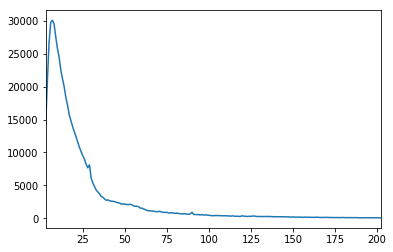

In [71]:
df = all_cycle_df[1]
#plt.ylim(0,1500)
df['Trip Duration Minutes'].value_counts().sort_index().head(200).plot()

#cycle_df_only_0_2['Trip Duration Minutes'].value_counts().sort_index().head(40).plot()
#.sort_values(ascending=False)
#.head(50).plot()

Seems like the trip duration is an exponential decay.

In [85]:
for df in all_cycle_df:
    df['Checkout WeekDay'] = df['Checkout Date'].dt.day_name()
    
for df in all_weather_df:
    df['Weekday'] = df['Date'].dt.day_name()

cycle_df['Checkout WeekDay'] = \
        cycle_df['Checkout Date'].dt.day_name()

# weather_df['Weekday'] = weather_df['Date'].dt.day_name()

# cycle_df_no_0_2['Checkout WeekDay'] = \
#         cycle_trips_df['Checkout Date'].dt.day_name()


cycle_df['Checkout WeekDay'].head()

/Users/Danny/.virtualenvs/CS_329E/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0    Sunday
1    Sunday
2    Sunday
3    Sunday
4    Sunday
Name: Checkout WeekDay, dtype: object

In [86]:
df = all_cycle_df[1]

cycle_weekdays = df.groupby('Checkout WeekDay')
cycle_months   = df.groupby('Month')
cycle_checkout = df.groupby('Checkout Kiosk')
cycle_return   = df.groupby('Return Kiosk')

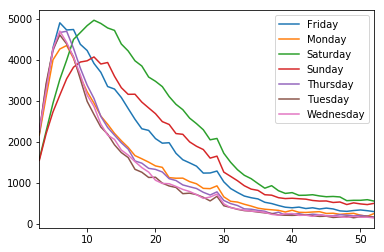

In [87]:
for name,group in cycle_weekdays:
    group['Trip Duration Minutes'].value_counts().sort_index()\
    .head(50).plot(legend=True,label=name)

## Notes  
Trips are twice as long on Saturday and Sunday then all other days. (~11-12 min compared to ~6-7)  
The distribution of Friday Saturday and Sunday is right shifted compared to the 4 days.  
Monday-Thursday distributions are nearly identical.   

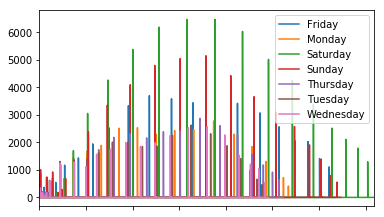

In [88]:
for index,(name,group) in enumerate(cycle_weekdays):
#     if index not in [1,6]:
#         continue
    group['Checkout Time'].value_counts().sort_index()\
    .plot(legend=True,label=name)

## Notes
Majority trips between midnight and 3 am are on saturday and sunday.  
Thursday, Tuesday, Monday are about the same. Thursday is slightly taller in the afternoon.  
Tuesday and Wednesday are practically identical.   
Monday is slightly taller than Wednesday during peak hours.  

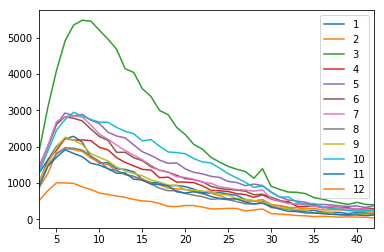

In [89]:
for index,(name,group) in enumerate(cycle_months):
#     if 4 < index < 9 :
#         continue
#     elif index >12:
#         continue 
    group['Trip Duration Minutes'].value_counts().sort_index()\
    .head(40).plot(legend=True,label=name)
    

## Notes
March is the most popular month.  
October and May are tied for second but October trips length are a bit longer.  
December is the least popular month by far.  
June through September are practically identical.  
January, February, and April are about the same, with February being the lowest.  
February is about tied with November.  

Overall there are 4 tiers:  
1. March 
2. May and October
3. All months besides December
4. December

In [90]:
for name,group in cycle_checkout:
    print('Checkout',name)
    print(group['Return Kiosk'].value_counts().head(5))#\
    print('\n')


Checkout 11th & San Jacinto
East 11th St. & San Marcos                 210
Davis at Rainey Street                     204
11th & San Jacinto                         184
Brazos & 6th                               165
Convention Center / 4th St. @ MetroRail    132
Name: Return Kiosk, dtype: int64


Checkout 13th & San Antonio
13th & San Antonio                   97
West & 6th St.                       35
City Hall / Lavaca & 2nd             33
Convention Center / 3rd & Trinity    21
8th & Congress                       19
Name: Return Kiosk, dtype: int64


Checkout 17th & Guadalupe
17th & Guadalupe                         509
West & 6th St.                           487
Republic Square @ Guadalupe & 4th St.    417
UT West Mall @ Guadalupe                 403
City Hall / Lavaca & 2nd                 361
Name: Return Kiosk, dtype: int64


Checkout 2nd & Congress
2nd & Congress              3681
South Congress & James      1242
South Congress & Academy    1215
Davis at Rainey Street      11

South Congress & James               1362
2nd & Congress                       1289
4th & Congress                        733
City Hall / Lavaca & 2nd              635
Capitol Station / Congress & 11th     619
Name: Return Kiosk, dtype: int64


Checkout State Capitol @ 14th & Colorado
State Capitol @ 14th & Colorado    704
UT West Mall @ Guadalupe           387
Bullock Museum @ Congress & MLK    366
Guadalupe & 21st                   266
4th & Congress                     168
Name: Return Kiosk, dtype: int64


Checkout State Capitol Visitors Garage @ San Jacinto & 12th
State Capitol Visitors Garage @ San Jacinto & 12th    1109
Capitol Station / Congress & 11th                      254
Bullock Museum @ Congress & MLK                        245
4th & Congress                                         201
Convention Center / 4th St. @ MetroRail                152
Name: Return Kiosk, dtype: int64


Checkout State Parking Garage @ Brazos & 18th
State Parking Garage @ Brazos & 18th    29
2nd &

In [147]:
df = cycle_df
df = cycle_df_no_0_2

checkout_return_pairs = df.\
    groupby(['Checkout Kiosk','Return Kiosk']).size().reset_index()\
    .rename(columns={0:'counts'}) #.value_counts().head(15).plot(kind='bar')

checkout_return_pairs = checkout_return_pairs\
    .sort_values('counts', ascending=False).reset_index()

# total_trips = checkout_return_pairs['counts'].sum()

# checkout_return_pairs['freq_%'] = checkout_return_pairs['counts']\
#     .map(lambda x: round(x/total_trips*100,4))


print(checkout_return_pairs.shape)

checkout_return_pairs.head(100)

(5098, 4)


index                                     Checkout Kiosk  \
0    3949                               Riverside @ S. Lamar   
1    3574                               Rainey St @ Cummings   
2     196                                     2nd & Congress   
3    1572                           City Hall / Lavaca & 2nd   
4    4987                                        Zilker Park   
5    5097  Zilker Park at Barton Springs & William Barton...   
6    3355                      Pfluger Bridge @ W 2nd Street   
7    1489                  Capitol Station / Congress & 11th   
8    3225                                  Palmer Auditorium   
9     993                         Barton Springs & Riverside   
10   1153                                Barton Springs Pool   
11    439                                        5th & Bowie   
12   2735                Long Center @ South 1st & Riverside   
13   2942           MoPac Pedestrian Bridge @ Veterans Drive   
14    357                                     4th & Congress   
15   1903                             Davis at Rainey Street   
16    457                                        5th & Bowie   
17   1767            Convention Center / 4th St. @ MetroRail   
18    296                                         3rd & West   
19   1072                        Barton Springs @ Kinney Ave   
20   1764            Convention Center / 4th St. @ MetroRail   
21   4052                           South Congress & Academy   
22    356                                     4th & Congress   
23   1555                           City Hall / Lavaca & 2nd   
24   3823              Republic Square @ Guadalupe & 4th St.   
25   3539                               Rainey St @ Cummings   
26    460                                        5th & Bowie   
27    278                                         3rd & West   
28    440                                        5th & Bowie   
29   3910                               Riverside @ S. Lamar   
30   1612                           City Hall / Lavaca & 2nd   
31   1691                  Convention Center / 3rd & Trinity   
32   1575                           City Hall / Lavaca & 2nd   
33   4333                             South Congress & James   
34   3942                               Riverside @ S. Lamar   
35    437                                        5th & Bowie   
36   4272                             South Congress & James   
37   4767                           UT West Mall @ Guadalupe   
38   1950                             Davis at Rainey Street   
39    260                                     2nd & Congress   
40   3963                               Riverside @ S. Lamar   
41   3965                               Riverside @ S. Lamar   
42   3904                               Riverside @ S. Lamar   
43    257                                     2nd & Congress   
44    355                                     4th & Congress   
45   3580                               Rainey St @ Cummings   
46   1900                             Davis at Rainey Street   
47   1553                           City Hall / Lavaca & 2nd   
48    498                                        5th & Bowie   
49    696                                     8th & Congress   
50   1344                    Bullock Museum @ Congress & MLK   
51   1877                             Davis at Rainey Street   
52   1747            Convention Center / 4th St. @ MetroRail   
53   4482  State Capitol Visitors Garage @ San Jacinto & ...   
54   3326                      Pfluger Bridge @ W 2nd Street   
55   3939                               Riverside @ S. Lamar   
56   4256                         South Congress & Elizabeth   
57    222                                     2nd & Congress   
58   4113                           South Congress & Academy   
59   1605                           City Hall / Lavaca & 2nd   
60   1472                  Capitol Station / Congress & 11th   
61   1879                           

In [148]:
df = all_cycle_df[1]

groups = df.\
    groupby(['Checkout Kiosk','Return Kiosk'])


columns = ['Checkout Kiosk','Return Kiosk', 'Avg Trip Duration', 
          'Mode Trip Duration']
checkout_return_pairs_avg = pd.DataFrame(columns=columns)
for (checkout, checkin),group in groups:
    checkout_return_pairs_avg = checkout_return_pairs_avg\
        .append({col_name: value for col_name, value in 
                 zip(columns,[checkout,checkin,
                group['Trip Duration Minutes'].mean(),
                group['Trip Duration Minutes'].mode().max()])
                }, ignore_index=True)

checkout_return_pairs_avg.shape

# .size().reset_index()\
#     .rename(columns={0:'counts'})

(5098, 4)

In [93]:
checkout_return_pairs_avg.head(20)

Checkout Kiosk                             Return Kiosk  \
0   11th & San Jacinto                       11th & San Jacinto   
1   11th & San Jacinto                       13th & San Antonio   
2   11th & San Jacinto                         17th & Guadalupe   
3   11th & San Jacinto                           2nd & Congress   
4   11th & San Jacinto                               3rd & West   
5   11th & San Jacinto                           4th & Congress   
6   11th & San Jacinto                              5th & Bowie   
7   11th & San Jacinto                         5th & San Marcos   
8   11th & San Jacinto                           6th & Congress   
9   11th & San Jacinto                           8th & Congress   
10  11th & San Jacinto                  ACC - Rio Grande & 12th   
11  11th & San Jacinto                        ACC - West & 12th   
12  11th & San Jacinto                 ACC - West & 12th Street   
13  11th & San Jacinto               Barton Springs & Riverside   
14  11th & San Jacinto              Barton Springs @ Kinney Ave   
15  11th & San Jacinto                      Barton Springs Pool   
16  11th & San Jacinto                           Boardwalk West   
17  11th & San Jacinto                             Brazos & 6th   
18  11th & San Jacinto          Bullock Museum @ Congress & MLK   
19  11th & San Jacinto  Capital Metro HQ - East 5th at Broadway   

    Avg Trip Duration Mode Trip Duration  
0           46.386282                  0  
1           20.500000                 30  
2           20.675676                  7  
3           22.805970                  8  
4           11.130435                  9  
5           11.545455                  6  
6           27.388889                 10  
7           14.115385                 15  
8           27.125000                  4  
9           17.477064                  2  
10          13.555556                  6  
11          36.000000                 36  
12          57.760000                 10  
13          20.083333                 14  
14          53.062500                 16  
15          46.909091                 59  
16          28.500000                 29  
17           7.688235                  4  
18          31.921569                  7  
19          17.341463                 17

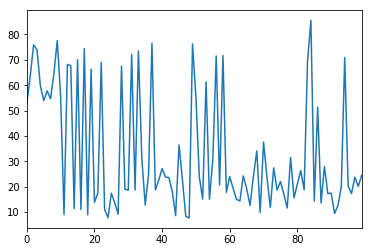

In [149]:
checkout_return_pair_data = pd.merge(checkout_return_pairs, 
                                     checkout_return_pairs_avg,
                                     how='inner',
                                    left_on=['Checkout Kiosk',
                                             'Return Kiosk'],
                                    right_on=['Checkout Kiosk',
                                             'Return Kiosk'],
                                    )
checkout_return_pair_data.drop(columns='index', inplace=True)
checkout_return_pair_data['Avg Trip Duration'].head(100).plot()


## Note
Most of the long trip durations are returned to the station they were checked out of.

All of the short trips are returned at a different station.

In [150]:
checkout_return_pair_data[checkout_return_pair_data[
    'Avg Trip Duration'
] < 15].head(10)


Checkout Kiosk  \
11                              5th & Bowie   
14                           4th & Congress   
16                              5th & Bowie   
18                               3rd & West   
20  Convention Center / 4th St. @ MetroRail   
23                 City Hall / Lavaca & 2nd   
24    Republic Square @ Guadalupe & 4th St.   
26                              5th & Bowie   
27                               3rd & West   
35                              5th & Bowie   

                               Return Kiosk  counts  Avg Trip Duration  \
11                           4th & Congress    2429           8.991354   
14                              5th & Bowie    2251          11.327410   
16                 City Hall / Lavaca & 2nd    2124          11.005179   
18                 City Hall / Lavaca & 2nd    1855           8.933693   
20                 City Hall / Lavaca & 2nd    1790          13.854749   
23                              5th & Bowie    1666          11.029412   
24                              5th & Bowie    1653           7.770115   
26  Convention Center / 4th St. @ MetroRail    1509          13.652750   
27                           4th & Congress    1499           9.168779   
35                           2nd & Congress    1318          12.780728   

   Mode Trip Duration  
11                  6  
14                  6  
16                  5  
18                  4  
20                  5  
23                  5  
24                  4  
26                  8  
27                  5  
35                  7

In [151]:
checkout_return_pair_data[checkout_return_pair_data[
    'Avg Trip Duration'
] > 25].head(10)

Checkout Kiosk  \
0                               Riverside @ S. Lamar   
1                               Rainey St @ Cummings   
2                                     2nd & Congress   
3                           City Hall / Lavaca & 2nd   
4                                        Zilker Park   
5  Zilker Park at Barton Springs & William Barton...   
6                      Pfluger Bridge @ W 2nd Street   
7                  Capitol Station / Congress & 11th   
8                                  Palmer Auditorium   
9                         Barton Springs & Riverside   

                                        Return Kiosk  counts  \
0                               Riverside @ S. Lamar    7799   
1                               Rainey St @ Cummings    4997   
2                                     2nd & Congress    3681   
3                           City Hall / Lavaca & 2nd    3422   
4                                        Zilker Park    3226   
5  Zilker Park at Barton Springs & William Barton...    3125   
6                      Pfluger Bridge @ W 2nd Street    3077   
7                  Capitol Station / Congress & 11th    2929   
8                                  Palmer Auditorium    2571   
9                         Barton Springs & Riverside    2527   

   Avg Trip Duration Mode Trip Duration  
0          52.916015                 27  
1          63.470082                 25  
2          75.861451                 29  
3          74.004383                  3  
4          59.846559                 44  
5          53.919360                 24  
6          57.786155                 27  
7          54.652783                 29  
8          64.497083                 11  
9          77.552434                 58

In [152]:
checkout_return_pair_data.sort_values(
    'Avg Trip Duration', ascending=False, inplace=True
)
checkout_return_pair_data.head(25)

Checkout Kiosk      Return Kiosk  \
4856                        Barton Springs @ Kinney Ave            Stolen   
4617                      Pfluger Bridge @ W 2nd Street            Stolen   
5061                                     8th & Congress         Main Shop   
4644                                     West & 6th St.       Repair Shop   
5083                                     8th & Congress            Stolen   
4272                               Trinity & 6th Street            Stolen   
4869                                     Mobile Station           Missing   
5066                               Trinity & 6th Street         Main Shop   
4975  State Capitol Visitors Garage @ San Jacinto & ...            Stolen   
4927                Long Center @ South 1st & Riverside           Missing   
4740                             Davis at Rainey Street           Missing   
4725            Convention Center / 4th St. @ MetroRail            Stolen   
4634                                     4th & Congress           Missing   
4821                                        Zilker Park            Stolen   
4903                                   17th & Guadalupe            Stolen   
4804                                     Plaza Saltillo       Main Office   
4568                          East 6th & Pedernales St.  Customer Service   
4999            Convention Center / 4th St. @ MetroRail           Missing   
5027                            ACC - Rio Grande & 12th           Missing   
4726                                 6th & Navasota St.       Repair Shop   
4623                             Red River & 8th Street           Missing   
4613                           UT West Mall @ Guadalupe           Missing   
4865                               Rainey St @ Cummings           Missing   
4935                            Toomey Rd @ South Lamar            Stolen   
4278                                     4th & Congress              Shop   

      counts  Avg Trip Duration Mode Trip Duration  
4856       1           21296.00              21296  
4617       2            7692.50              13981  
5061       1            7670.00               7670  
4644       2            7626.00               9118  
5083       1            6609.00               6609  
4272       4            6304.25               7902  
4869       1            5950.00               5950  
5066       1            5089.00               5089  
4975       1            4833.00               4833  
4927       1            4659.00               4659  
4740       2            4310.00               5566  
4725       2            4069.50               5189  
4634       2            3703.50               3913  
4821       1            3632.00               3632  
4903       1            3624.00               3624  
4804       2            3477.00               6931  
4568       2            3424.50               3425  
4999       1            3279.00               3279  
5027       1            3193.00               3193  
4726       2            3169.50               4758  
4623       2            3153.50               3154  
4613       2            3054.00               4295  
4865       1            3000.00               3000  
4935       1            2863.00               2863  
4278       4            2658.00               6584

In [164]:
rm_kiosk = ['Stolen','Missing',
              'Main Shop','Repair Shop', 'Shop',
              'Customer Service','Main Office',]
cleaned_checkout_return_pair_data = checkout_return_pair_data[
    ~checkout_return_pair_data['Return Kiosk'].isin(rm_kiosk) &
    ~checkout_return_pair_data['Checkout Kiosk'].isin(rm_kiosk)
]


cleaned_checkout_return_pair_data[
    cleaned_checkout_return_pair_data['counts'] > 100
]

Checkout Kiosk  \
1300                  East 11th Street at Victory Grill   
158                              Red River & 8th Street   
201                                        Brazos & 6th   
84                             San Jacinto & 8th Street   
261                                    17th & Guadalupe   
9                            Barton Springs & Riverside   
663                      East 11th St. at Victory Grill   
37                             UT West Mall @ Guadalupe   
689                            South Congress & Academy   
49                                       8th & Congress   
2                                        2nd & Congress   
17              Convention Center / 4th St. @ MetroRail   
1184                                     6th & Congress   
425                           East 6th & Pedernales St.   
3                              City Hall / Lavaca & 2nd   
33                               South Congress & James   
867                    Convention Center/ 3rd & Trinity   
437                            UT West Mall @ Guadalupe   
31                    Convention Center / 3rd & Trinity   
58                             South Congress & Academy   
56                           South Congress & Elizabeth   
131   South Congress & Barton Springs at the Austin ...   
116               Republic Square @ Guadalupe & 4th St.   
681                                        Lavaca & 6th   
94                                 Trinity & 6th Street   
1050              Republic Square @ Guadalupe & 4th St.   
15                               Davis at Rainey Street   
873          Republic Square @ Federal Courthouse Plaza   
923                                  11th & San Jacinto   
83                                     Guadalupe & 21st   
22                                       4th & Congress   
1163                                       Brazos & 6th   
258                          East 11th St. & San Marcos   
203                                      Plaza Saltillo   
334                          Barton Springs & Riverside   
12                  Long Center @ South 1st & Riverside   
625                               East 2nd & Pedernales   
417                                    Guadalupe & 21st   
1264                                     8th & Congress   
13             MoPac Pedestrian Bridge @ Veterans Drive   
28                                          5th & Bowie   
964                                Trinity & 6th Street   
1220                                 6th & Navasota St.   
19                          Barton Springs @ Kinney Ave   
657                                Trinity & 6th Street   
405                         East 6th at Robert Martinez   
896                                   East 4th & Chicon   
299                             Toomey Rd @ South Lamar   
1167                               Rainey St @ Cummings   
8                                     Palmer Auditorium   
1317                            ACC - Rio Grande & 12th   
1                                  Rainey St @ Cummings   
603                   Convention Center / 3rd & Trinity   
613                          South Congress & Elizabeth   
53    State Capitol Visitors Garage @ San Jacinto & ...   
150                                          3rd & West   
660                 Long Center @ South 1st & Riverside   
432                                    Waller & 6th St.   
4                                           Zilker Park   
319                                    5th & San Marcos   
149                     State Capitol @ 14th & Colorado   
1268              Republic Square @ Guadalupe & 4th St.   
759                                   ACC - West & 12th   
911                   Capitol Station / Congress & 11th   
1221                                       Nueces & 3rd   
6                         Pfluger Bridge @ W 2nd Street   
954                                      Boardwalk West   
752             Convention Ce

In [165]:
bad_checkout_return_pair_data = checkout_return_pair_data[
    checkout_return_pair_data['Return Kiosk'].isin(rm_kiosk) |
    checkout_return_pair_data['Checkout Kiosk'].isin(rm_kiosk)
]

bad_checkout_return_pair_data.sort_values(
    'counts', ascending=False, inplace=True
)

print('Not Real Trips: ',bad_checkout_return_pair_data.counts.sum())

bad_checkout_return_pair_data.head(100)

Not Real Trips:  968


/Users/Danny/.virtualenvs/CS_329E/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Checkout Kiosk  \
1683                         East 11th St. & San Marcos   
1709                                        Main Office   
2137  State Capitol Visitors Garage @ San Jacinto & ...   
2456                                        Main Office   
3261                                        5th & Bowie   
3284                         East 11th St. & San Marcos   
3394                                        Main Office   
3470            Convention Center / 4th St. @ MetroRail   
3463                         South Congress & Elizabeth   
3493                                        Main Office   
3496                                   17th & Guadalupe   
3534                                        Main Office   
3629                                        Main Office   
3600  State Capitol Visitors Garage @ San Jacinto & ...   
3627                                        Main Office   
3724                         Barton Springs & Riverside   
3697                                     2nd & Congress   
3787                                        Main Office   
3794                               Trinity & 6th Street   
3786                                        Main Office   
3807                                     4th & Congress   
3801                                        5th & Bowie   
3887                           City Hall / Lavaca & 2nd   
3836                                Barton Springs Pool   
3893                  Capitol Station / Congress & 11th   
3874                               Trinity & 6th Street   
3965                               Rainey St @ Cummings   
3918            Convention Center / 4th St. @ MetroRail   
3901                                     4th & Congress   
3936                  Capitol Station / Congress & 11th   
4078                             Red River & 8th Street   
4008                                        Main Office   
3999                             South Congress & James   
4004                  Convention Center / 3rd & Trinity   
4059                         Barton Springs & Riverside   
4046                         South Congress & Elizabeth   
4003                                        Main Office   
4054              Republic Square @ Guadalupe & 4th St.   
3987                                        Main Office   
4197                Long Center @ South 1st & Riverside   
4173                                        Main Office   
4214                                   5th & San Marcos   
4144                           City Hall / Lavaca & 2nd   
4138                     East 11th St. at Victory Grill   
4163                                        Main Office   
4181                                        Main Office   
4136                         East 11th St. & San Marcos   
4109                                     4th & Congress   
4199                                     West & 6th St.   
4164                  Capitol Station / Congress & 11th   
4165                                        Main Office   
4200                           UT West Mall @ Guadalupe   
4169                               Trinity & 6th Street   
4393                                        Main Office   
4391                                        Main Office   
4255                  Convention Center / 3rd & Trinity   
4325                             Davis at Rainey Street   
4359              Republic Square @ Guadalupe & 4th St.   
4349              Republic Square @ Guadalupe & 4th St.   
4260                                     8th & Congress   
4394                               Riverside @ S. Lamar   
4369                           South Congress & Academy   
4244  Zilker Park at Barton Springs & William Barton...   
4240                         Barton Springs & Riverside   
4328                             Davis at Rainey Street   
4263            Convention Center / 4th St. @ MetroRail   
4395                                     2nd & Congress   
4278                         

## Notes
968 trips are not real. 681 come from not having a real Return Kiosk.  
These are bikes that were checked out and were not checked back in for another customer to use. 

## New DataFrame

Organizing all Checkout/Return pairs by month for each year.  


In [180]:
df = all_cycle_df[1]
df = df[
    ~df['Checkout Kiosk'].isin(rm_kiosk) &
    ~df['Return Kiosk'].isin(rm_kiosk)
]

checkout_return_pairs_by_month = df.\
    groupby(['Month','Year','Checkout Kiosk','Return Kiosk'])\
    .size().reset_index()\
    .rename(columns={0:'counts'}) #.value_counts().head(15).plot(kind='bar')


checkout_return_pairs_by_month = checkout_return_pairs_by_month\
    .sort_values(['Checkout Kiosk','counts','Month', 'Year'],
                ascending=[True, False, True, True]).reset_index()

# total_trips = checkout_return_pairs['counts'].sum()

# checkout_return_pairs['freq_%'] = checkout_return_pairs['counts']\
#     .map(lambda x: round(x/total_trips*100,4))

checkout_return_pairs_by_month.drop(columns='index', inplace=True)


print(checkout_return_pairs_by_month.shape)

checkout_return_pairs_by_month.head(100)

(67035, 5)


Month  Year      Checkout Kiosk  \
0      10  2016  11th & San Jacinto   
1       9  2016  11th & San Jacinto   
2       3  2016  11th & San Jacinto   
3       8  2016  11th & San Jacinto   
4      11  2016  11th & San Jacinto   
5      10  2015  11th & San Jacinto   
6       3  2017  11th & San Jacinto   
7       3  2017  11th & San Jacinto   
8       5  2017  11th & San Jacinto   
9       7  2017  11th & San Jacinto   
10      1  2017  11th & San Jacinto   
11      3  2017  11th & San Jacinto   
12      4  2017  11th & San Jacinto   
13     10  2016  11th & San Jacinto   
14     10  2016  11th & San Jacinto   
15      2  2017  11th & San Jacinto   
16      1  2017  11th & San Jacinto   
17      3  2017  11th & San Jacinto   
18      3  2017  11th & San Jacinto   
19      5  2016  11th & San Jacinto   
20      6  2017  11th & San Jacinto   
21      6  2017  11th & San Jacinto   
22      7  2016  11th & San Jacinto   
23      9  2016  11th & San Jacinto   
24     10  2015  11th & San Jacinto   
25      3  2016  11th & San Jacinto   
26      3  2016  11th & San Jacinto   
27      3  2016  11th & San Jacinto   
28      3  2016  11th & San Jacinto   
29      8  2015  11th & San Jacinto   
30      8  2016  11th & San Jacinto   
31      9  2015  11th & San Jacinto   
32      9  2015  11th & San Jacinto   
33      9  2016  11th & San Jacinto   
34      4  2017  11th & San Jacinto   
35      6  2016  11th & San Jacinto   
36      6  2017  11th & San Jacinto   
37      7  2017  11th & San Jacinto   
38     10  2015  11th & San Jacinto   
39     11  2016  11th & San Jacinto   
40      2  2017  11th & San Jacinto   
41      3  2016  11th & San Jacinto   
42      5  2016  11th & San Jacinto   
43      5  2016  11th & San Jacinto   
44      5  2017  11th & San Jacinto   
45      5  2017  11th & San Jacinto   
46      6  2016  11th & San Jacinto   
47      6  2016  11th & San Jacinto   
48      6  2016  11th & San Jacinto   
49      6  2017  11th & San Jacinto   
50      7  2016  11th & San Jacinto   
51      7  2017  11th & San Jacinto   
52      9  2016  11th & San Jacinto   
53     10  2015  11th & San Jacinto   
54      1  2016  11th & San Jacinto   
55      1  2016  11th & San Jacinto   
56      3  2016  11th & San Jacinto   
57      3  2016  11th & San Jacinto   
58      3  2016  11th & San Jacinto   
59      3  2017  11th & San Jacinto   
60      3  2017  11th & San Jacinto   
61      4  2017  11th & San Jacinto   
62      5  2016  11th & San Jacinto   
63      5  2016  11th & San Jacinto   
64      7  2016  11th & San Jacinto   
65      7  2016  11th & San Jacinto   
66      7  2016  11th & San Jacinto   
67     10  2015  11th & San Jacinto   
68     10  2015  11th & San Jacinto   
69     10  2016  11th & San Jacinto   
70     11  2016  11th & San Jacinto   
71      1  2017  11th & San Jacinto   
72      2  2016  11th & San Jacinto   
73      2  2016  11th & San Jacinto   
74      3  2016  11th & San Jacinto   
75      3  2016  11th & San Jacinto   
76      3  2017  11th & San Jacinto   
77      4  2017  11th & San Jacinto   
78      6  2016  11th & San Jacinto   
79      7  2017  11th & San Jacinto   
80      9  2016  11th & San Jacinto   
81     10  2015  11th & San Jacinto   
82     10  2016  11th & San Jacinto   
83     10  2016  11th & San Jacinto   
84     10  2016  11th & San Jacinto   
85     11  2016  11th & San Jacinto   
86      1  2016  11th & San Jacinto   
87      1  2016  11th & San Jacinto   
88      1  2016  11th & San Jacinto   
89      2  2016  11th & San Jacinto   
90      2  2017  11th & San Jacinto   
91      4  2017  11th & San Jacinto   
92      5  2016  11th & San Jacinto   
93      5  2017  11th & San Jacinto   
94      6  2017  11th & San Jacinto   
95      6  2017  11th & San Jacinto   
96      9  2015  11th & San Jacinto   
97      9  2015  11th & San Jacinto   
98      9  2015  11th & San Jacinto   
99     10  2015  11th & San Jacinto   

                                         Return Kiosk  counts  


## Creating the averages and modes for each month

In [206]:
groups = df.groupby(['Month','Year',
                     'Checkout Kiosk',
                     'Return Kiosk'])


columns = ['Month','Year','Checkout Kiosk','Return Kiosk', 'Avg Trip Duration', 
          'Mode Max Trip Duration', 'Mode Min Trip Duration']
checkout_return_pairs_avg_by_month = pd.DataFrame(columns=columns)
for name,group in groups:
#     print(name, 
#           group['Trip Duration Minutes'].mean(),
#           group['Trip Duration Minutes'].mode().values,
#           sep='\n'
#          )
    checkout_return_pairs_avg_by_month = \
    checkout_return_pairs_avg_by_month.append(
        {col_name: value for col_name, value in zip(
            columns,
            [*name, 
            group['Trip Duration Minutes'].mean(),
            group['Trip Duration Minutes'].mode().max(),
            group['Trip Duration Minutes'].mode().min()
                ])
        },
        ignore_index=True
    )

    
checkout_return_pairs_avg_by_month.head(15)
    
#     checkout_return_pairs_avg_by_month = \
#     checkout_return_pairs_avg_by_month\
#         .append({col_name: value for col_name, value in 
#                  zip(columns,[checkout,checkin,
#                 group['Trip Duration Minutes'].mean(),
#                 group['Trip Duration Minutes'].mode().max()])
#                 }, ignore_index=True)

Month  Year    Checkout Kiosk                             Return Kiosk  \
0      1  2014  17th & Guadalupe                         17th & Guadalupe   
1      1  2014  17th & Guadalupe                              5th & Bowie   
2      1  2014  17th & Guadalupe        Capitol Station / Congress & 11th   
3      1  2014  17th & Guadalupe                          Republic Square   
4      1  2014    2nd & Congress                           2nd & Congress   
5      1  2014    2nd & Congress                           4th & Congress   
6      1  2014    2nd & Congress                              5th & Bowie   
7      1  2014    2nd & Congress                       6th & Navasota St.   
8      1  2014    2nd & Congress                           8th & Congress   
9      1  2014    2nd & Congress               Barton Springs & Riverside   
10     1  2014    2nd & Congress        Capitol Station / Congress & 11th   
11     1  2014    2nd & Congress                 City Hall / Lavaca & 2nd   
12     1  2014    2nd & Congress  Convention Center / 4th St. @ MetroRail   
13     1  2014    2nd & Congress                          Republic Square   
14     1  2014    2nd & Congress               South Congress & Elizabeth   

    Avg Trip Duration Mode Max Trip Duration Mode Min Trip Duration  
0           44.333333                    107                     10  
1           13.500000                     18                      9  
2            6.000000                      8                      4  
3           12.000000                     12                     12  
4           49.815385                     43                     26  
5           21.250000                     31                      3  
6           20.000000                      7                      7  
7           18.000000                     18                     18  
8            7.571429                      5                      4  
9           20.529412                      8                      8  
10          34.384615                     23                     23  
11          20.181818                      6                      6  
12          34.250000                     62                     10  
13           6.200000                      5                      4  
14          20.285714                     30                      8

## Merging Columns for by month data

In [210]:
pair_data_by_month = pd.merge(checkout_return_pairs_by_month, 
                              checkout_return_pairs_avg_by_month,
                              how='inner',
                              left_on=['Month','Year',
                                       'Checkout Kiosk',
                                       'Return Kiosk'],
                              right_on=['Month','Year',
                                        'Checkout Kiosk',
                                        'Return Kiosk'],
                                    )
#pair_data_by_month.drop(columns='index', inplace=True)
pair_data_by_month.head(100)

Month  Year      Checkout Kiosk  \
0     10  2016  11th & San Jacinto   
1      9  2016  11th & San Jacinto   
2      3  2016  11th & San Jacinto   
3      8  2016  11th & San Jacinto   
4     11  2016  11th & San Jacinto   
5     10  2015  11th & San Jacinto   
6      3  2017  11th & San Jacinto   
7      3  2017  11th & San Jacinto   
8      5  2017  11th & San Jacinto   
9      7  2017  11th & San Jacinto   
10     1  2017  11th & San Jacinto   
11     3  2017  11th & San Jacinto   
12     4  2017  11th & San Jacinto   
13    10  2016  11th & San Jacinto   
14    10  2016  11th & San Jacinto   
15     2  2017  11th & San Jacinto   
16     1  2017  11th & San Jacinto   
17     3  2017  11th & San Jacinto   
18     3  2017  11th & San Jacinto   
19     5  2016  11th & San Jacinto   
20     6  2017  11th & San Jacinto   
21     6  2017  11th & San Jacinto   
22     7  2016  11th & San Jacinto   
23     9  2016  11th & San Jacinto   
24    10  2015  11th & San Jacinto   
25     3  2016  11th & San Jacinto   
26     3  2016  11th & San Jacinto   
27     3  2016  11th & San Jacinto   
28     3  2016  11th & San Jacinto   
29     8  2015  11th & San Jacinto   
30     8  2016  11th & San Jacinto   
31     9  2015  11th & San Jacinto   
32     9  2015  11th & San Jacinto   
33     9  2016  11th & San Jacinto   
34     4  2017  11th & San Jacinto   
35     6  2016  11th & San Jacinto   
36     6  2017  11th & San Jacinto   
37     7  2017  11th & San Jacinto   
38    10  2015  11th & San Jacinto   
39    11  2016  11th & San Jacinto   
40     2  2017  11th & San Jacinto   
41     3  2016  11th & San Jacinto   
42     5  2016  11th & San Jacinto   
43     5  2016  11th & San Jacinto   
44     5  2017  11th & San Jacinto   
45     5  2017  11th & San Jacinto   
46     6  2016  11th & San Jacinto   
47     6  2016  11th & San Jacinto   
48     6  2016  11th & San Jacinto   
49     6  2017  11th & San Jacinto   
50     7  2016  11th & San Jacinto   
51     7  2017  11th & San Jacinto   
52     9  2016  11th & San Jacinto   
53    10  2015  11th & San Jacinto   
54     1  2016  11th & San Jacinto   
55     1  2016  11th & San Jacinto   
56     3  2016  11th & San Jacinto   
57     3  2016  11th & San Jacinto   
58     3  2016  11th & San Jacinto   
59     3  2017  11th & San Jacinto   
60     3  2017  11th & San Jacinto   
61     4  2017  11th & San Jacinto   
62     5  2016  11th & San Jacinto   
63     5  2016  11th & San Jacinto   
64     7  2016  11th & San Jacinto   
65     7  2016  11th & San Jacinto   
66     7  2016  11th & San Jacinto   
67    10  2015  11th & San Jacinto   
68    10  2015  11th & San Jacinto   
69    10  2016  11th & San Jacinto   
70    11  2016  11th & San Jacinto   
71     1  2017  11th & San Jacinto   
72     2  2016  11th & San Jacinto   
73     2  2016  11th & San Jacinto   
74     3  2016  11th & San Jacinto   
75     3  2016  11th & San Jacinto   
76     3  2017  11th & San Jacinto   
77     4  2017  11th & San Jacinto   
78     6  2016  11th & San Jacinto   
79     7  2017  11th & San Jacinto   
80     9  2016  11th & San Jacinto   
81    10  2015  11th & San Jacinto   
82    10  2016  11th & San Jacinto   
83    10  2016  11th & San Jacinto   
84    10  2016  11th & San Jacinto   
85    11  2016  11th & San Jacinto   
86     1  2016  11th & San Jacinto   
87     1  2016  11th & San Jacinto   
88     1  2016  11th & San Jacinto   
89     2  2016  11th & San Jacinto   
90     2  2017  11th & San Jacinto   
91     4  2017  11th & San Jacinto   
92     5  2016  11th & San Jacinto   
93     5  2017  11th & San Jacinto   
94     6  2017  11th & San Jacinto   
95     6  2017  11th & San Jacinto   
96     9  2015  11th & San Jacinto   
97     9  2015  11th & San Jacinto   
98     9  2015  11th & San Jacinto   
99    10  2015  11th & San Jacinto   

                                         Return Kiosk  counts  \
0                              Davis at Rainey Street      29   
1                              Dav

In [211]:
pair_data_by_month.to_csv('./data/kiosk_data_by_month.csv', index=False)

Month                      object
Year                       object
Checkout Kiosk             object
Return Kiosk               object
counts                      int64
Avg Trip Duration         float64
Mode Max Trip Duration     object
Mode Min Trip Duration     object
dtype: object

In [205]:
checkout_return_pairs_avg_by_month_1.head()

Month  Year    Checkout Kiosk                       Return Kiosk  \
0     1  2014  17th & Guadalupe                   17th & Guadalupe   
1     1  2014  17th & Guadalupe                        5th & Bowie   
2     1  2014  17th & Guadalupe  Capitol Station / Congress & 11th   
3     1  2014  17th & Guadalupe                    Republic Square   
4     1  2014    2nd & Congress                     2nd & Congress   

   Avg Trip Duration Modes Trip Duration  
0          44.333333       [10, 16, 107]  
1          13.500000             [9, 18]  
2           6.000000              [4, 8]  
3          12.000000                [12]  
4          49.815385        [26, 27, 43]

In [203]:
checkout_return_pairs_avg_by_month['Modes Trip Duration']\
    .apply(np.array)

0                                            [10, 16, 107]
1                                                  [9, 18]
2                                                   [4, 8]
3                                                     [12]
4                                             [26, 27, 43]
5                                          [3, 25, 26, 31]
6                                                      [7]
7                                                     [18]
8                                                   [4, 5]
9                                                      [8]
10                                                    [23]
11                                                     [6]
12                                            [10, 25, 62]
13                                                  [4, 5]
14                             [8, 12, 20, 22, 23, 27, 30]
15                                                    [10]
16                                                     [